In [1]:
# !pip install transformers
# !pip install pandas
# !pip install scikit-learn

In [2]:
# !pip install seaborn


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

c:\Users\Sai Ram\Anaconda3\envs\udacity-cv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import operator
import re
import gc

In [5]:
# !pip install torch
# import torch
# !pip3 install torch==1.8.2 torchvision==0.9.2 torchaudio===0.8.2 --extra-index-url https://download.pytorch.org/whl/lts/1.8/cu111

In [6]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# torch.cuda.is_available()

In [8]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

In [9]:
# df = pd.read_csv('wellbeing.csv')
df = pd.read_csv('IMDB Dataset.csv')

In [10]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [11]:
df.shape

(50000, 2)

In [12]:
df.head()
df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [13]:
df['sentiment'] = df['sentiment'].replace('positive', 1)
df['sentiment'] = df['sentiment'].replace('negative', 0)

In [14]:
# Data Preprocessing

In [15]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [79]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [16]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [17]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.review:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

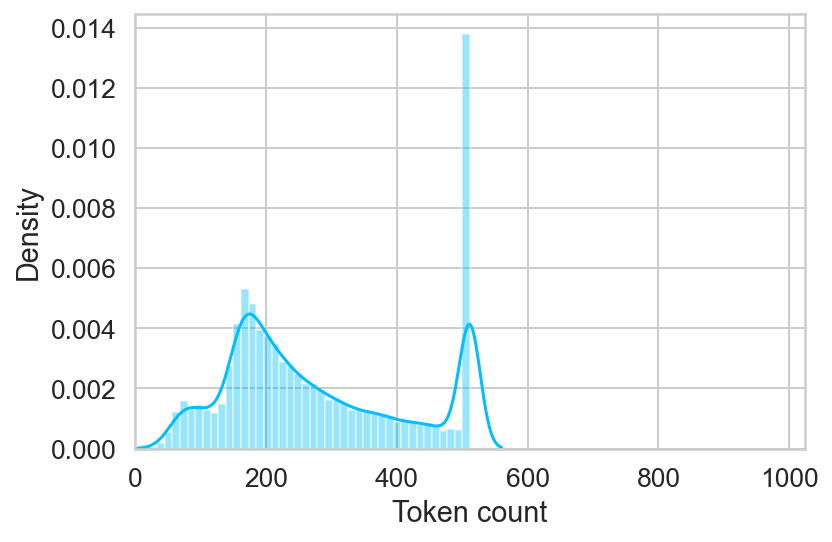

In [19]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 1024]);
plt.xlabel('Token count')

In [20]:
MAX_LEN = 512

In [21]:
# Torch Dataset

In [22]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [23]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(40000, 2) (5000, 2) (5000, 2)


In [24]:
glove_embeddings= np.load('../glove.840B.300d.pkl/glove.840B.300d.pkl',
                          allow_pickle=True)

In [25]:
def vocab_build(review):
    
    comments = review.apply(lambda s: s.split()).values
    vocab={}
    
    for comment in comments:
        for word in comment:
            try:
                vocab[word]+=1
                
            except KeyError:
                vocab[word]=1
    return vocab

In [26]:
def embedding_coverage(review,embeddings):
    
    vocab=vocab_build(review)
    
    covered={}
    word_count={}
    oov={}
    covered_num=0
    oov_num=0
    
    for word in vocab:
        try:
            covered[word]=embeddings[word]
            covered_num+=vocab[word]
            word_count[word]=vocab[word]
        except:
            oov[word]=vocab[word]
            oov_num+=oov[word]
    
    vocab_coverage=len(covered)/len(vocab)*100
    text_coverage = covered_num/(covered_num+oov_num)*100
    
    sorted_oov=sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    sorted_word_count=sorted(word_count.items(), key=operator.itemgetter(1))[::-1]
    
    return sorted_word_count,sorted_oov,vocab_coverage,text_coverage

In [27]:
train_covered,train_oov,train_vocab_coverage,train_text_coverage=embedding_coverage(df_train['review'],glove_embeddings)
test_covered,test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(df_test['review'],glove_embeddings)

print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in testing set")

Glove embeddings cover 27.56% of vocabulary and 87.64% text in training set
Glove embeddings cover 42.12% of vocabulary and 87.56% text in testing set


In [28]:
train_oov[:10]

[('/><br', 80952),
 ('/>The', 11484),
 ('film,', 6509),
 ('movie,', 6344),
 ('/>I', 5897),
 ("isn't", 4657),
 ('"The', 3913),
 ('/>This', 3492),
 ("he's", 3445),
 ("wasn't", 3362)]

In [29]:
def clean_sentences(line):
    
    line=re.sub('<.*?>','',line) # removing html tags
    
    #removing contractions
    line=re.sub("isn't",'is not',line)
    line=re.sub("he's",'he is',line)
    line=re.sub("wasn't",'was not',line)
    line=re.sub("there's",'there is',line)
    line=re.sub("couldn't",'could not',line)
    line=re.sub("won't",'will not',line)
    line=re.sub("they're",'they are',line)
    line=re.sub("she's",'she is',line)
    line=re.sub("There's",'there is',line)
    line=re.sub("wouldn't",'would not',line)
    line=re.sub("haven't",'have not',line)
    line=re.sub("That's",'That is',line)
    line=re.sub("you've",'you have',line)
    line=re.sub("He's",'He is',line)
    line=re.sub("what's",'what is',line)
    line=re.sub("weren't",'were not',line)
    line=re.sub("we're",'we are',line)
    line=re.sub("hasn't",'has not',line)
    line=re.sub("you'd",'you would',line)
    line=re.sub("shouldn't",'should not',line)
    line=re.sub("let's",'let us',line)
    line=re.sub("they've",'they have',line)
    line=re.sub("You'll",'You will',line)
    line=re.sub("i'm",'i am',line)
    line=re.sub("we've",'we have',line)
    line=re.sub("it's",'it is',line)
    line=re.sub("don't",'do not',line)
    line=re.sub("that´s",'that is',line)
    line=re.sub("I´m",'I am',line)
    line=re.sub("it’s",'it is',line)
    line=re.sub("she´s",'she is',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('I’m','I am',line)
    line=re.sub('I’d','I did',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('there’s','there is',line)
    
    #special characters and emojis
    line=re.sub('\x91The','The',line)
    line=re.sub('\x97','',line)
    line=re.sub('\x84The','The',line)
    line=re.sub('\uf0b7','',line)
    line=re.sub('¡¨','',line)
    line=re.sub('\x95','',line)
    line=re.sub('\x8ei\x9eek','',line)
    line=re.sub('\xad','',line)
    line=re.sub('\x84bubble','bubble',line)
    
    # # remove concated words
    # line=re.sub('trivialBoring','trivial Boring',line)
    # line=re.sub('Justforkix','Just for kix',line)
    # line=re.sub('Nightbeast','Night beast',line)
    # line=re.sub('DEATHTRAP','Death Trap',line)
    # line=re.sub('CitizenX','Citizen X',line)
    # line=re.sub('10Rated','10 Rated',line)
    # line=re.sub('_The','_ The',line)
    # line=re.sub('1Sound','1 Sound',line)
    # line=re.sub('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah','blah blah',line)
    # line=re.sub('ResidentHazard','Resident Hazard',line)
    # line=re.sub('iameracing','i am racing',line)
    # line=re.sub('BLACKSNAKE','Black Snake',line)
    # line=re.sub('DEATHSTALKER','Death Stalker',line)
    # line=re.sub('_is_','is',line)
    # line=re.sub('10Fans','10 Fans',line)
    # line=re.sub('Yellowcoat','Yellow coat',line)
    # line=re.sub('Spiderbabe','Spider babe',line)
    # line=re.sub('Frightworld','Fright world',line)
    
    #removing punctuations
    
    punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
    for p in punctuations:
        line = line.replace(p, f' {p} ')
        
    line=re.sub(',',' , ',line)
        
    # ... and ..
    line = line.replace('...', ' ... ')
    
    if '...' not in line:
        line = line.replace('..', ' ... ')
        
    return line

In [30]:
df_train['review']=df_train['review'].apply(lambda s: clean_sentences(s))
df_test['review']=df_test['review'].apply(lambda s: clean_sentences(s))

train_covered,train_oov,train_vocab_coverage,train_text_coverage=embedding_coverage(df_train['review'],glove_embeddings)
print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")

test_covered,test_oov,test_vocab_coverage,test_text_coverage=embedding_coverage(df_test['review'],glove_embeddings)
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in training set")

Glove embeddings cover 87.52% of vocabulary and 99.82% text in training set
Glove embeddings cover 95.73% of vocabulary and 99.83% text in training set


In [86]:
df_train

,review,sentiment
39087,That is what I kept asking myself during the m...,0
30893,I did not watch the entire movie . I could no...,0
45278,A touching love story reminiscent of In the M...,1
16398,This latter - day Fulci schlocker is a total...,0
13653,"First of all , I firmly believe that Norwegia...",0
...,...,...
11284,` Shadow Magic ' recaptures the joy and amaz...,1
44732,I found this movie to be quite enjoyable and f...,1
38158,Avoid this one ! It is a terrible movie . So...,0
860,This production was quite a surprise for me . ...,1


In [31]:
del glove_embeddings,train_oov,test_oov
gc.collect()

0

In [32]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.review.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [33]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [34]:
torch.cuda.empty_cache()
gc.collect()

0

In [35]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


In [36]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [38]:
class_names = ['negative', 'positive']

In [39]:
torch.cuda.empty_cache()
gc.collect()

218

In [40]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [42]:
# Training

In [43]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [44]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()
        gc.collect()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            torch.cuda.empty_cache()
            gc.collect()
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
torch.cuda.empty_cache()
gc.collect()
# torch.utils.checkpoint
# del variable

1441

In [47]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    torch.cuda.empty_cache()
    gc.collect()
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state_new.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 6.00 GiB total capacity; 5.20 GiB already allocated; 0 bytes free; 5.26 GiB reserved in total by PyTorch)

In [58]:
model.load_state_dict(torch.load('best_model_state_new_1.bin'))

<All keys matched successfully>

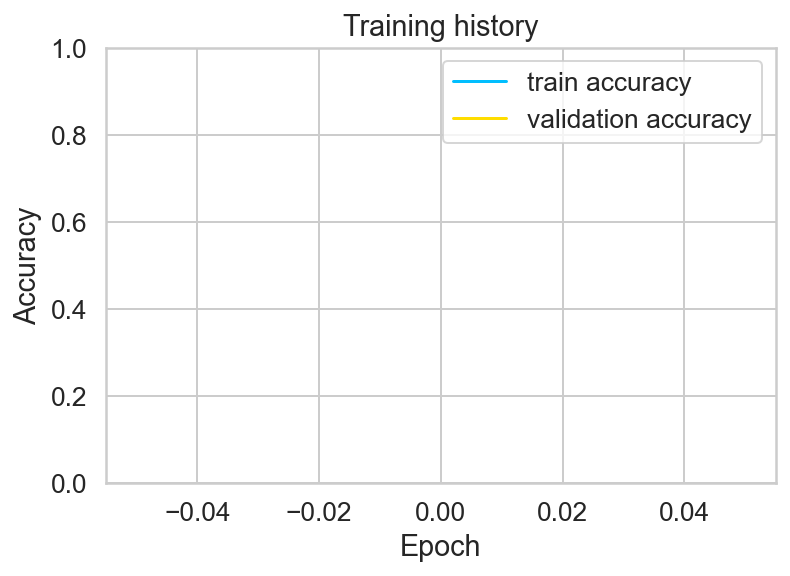

In [51]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.926

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                return_dict=False
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.92      0.94      0.93      2462
    positive       0.94      0.92      0.93      2538

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



In [70]:
review_text = "I am a career academic. I work incredibly long hours and management's expectations are impossible. Management talks about wellbeing but there is no actual support as workloads continue to increase. This jobs has killed my chances of a successful academic career because I am completely overloaded with teaching: only research success matters for career progression. I used to love my job, but that passion has died.Management pays lip service management to wellbeing but there is no action. They need to provide greater support."

In [129]:
a = ['I am a career academic . ', "I work incredibly long hours and management's expectations are impossible .", "Management talks about wellbeing but there is no actual support as workloads continue to increase . ",  "This jobs has killed my chances of a successful academic career because I am completely overloaded with teaching: only research success matters for career progression . ", "I used to love my job, but that passion has died . ", "Management pays lip service management to wellbeing but there is no action . ", "They need to provide greater support . "]

In [147]:
# a = np.array(a)
a

['I am a career academic . ',
 "I work incredibly long hours and management's expectations are impossible .",
 'Management talks about wellbeing but there is no actual support as workloads continue to increase . ',
 'This jobs has killed my chances of a successful academic career because I am completely overloaded with teaching: only research success matters for career progression . ',
 'I used to love my job, but that passion has died . ',
 'Management pays lip service management to wellbeing but there is no action . ',
 'They need to provide greater support . ']

In [71]:
def make_pred(review_text):
    encoded_review = tokenizer.encode_plus(
        review_text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    return class_names[prediction]

In [148]:
df_use_case = pd.DataFrame()

df_use_case['sentences'] = a
df_use_case

,sentences
0,I am a career academic .
1,I work incredibly long hours and management's ...
2,Management talks about wellbeing but there is ...
3,This jobs has killed my chances of a successfu...
4,"I used to love my job, but that passion has di..."
5,Management pays lip service management to well...
6,They need to provide greater support .


In [157]:
df_use_case['sentiment'] = df_use_case['sentences'].apply(lambda x: make_pred(x))

In [158]:
df_use_case

,sentences,sentiment
0,I am a career academic .,negative
1,I work incredibly long hours and management's ...,negative
2,Management talks about wellbeing but there is ...,negative
3,This jobs has killed my chances of a successfu...,negative
4,"I used to love my job, but that passion has di...",negative
5,Management pays lip service management to well...,negative
6,They need to provide greater support .,positive


In [128]:
df_use_case.to_csv('use_case.csv')

In [72]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [73]:
# encoded_review.keys()

In [74]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I am a career academic. I work incredibly long hours and management's expectations are impossible. Management talks about wellbeing but there is no actual support as workloads continue to increase. This jobs has killed my chances of a successful academic career because I am completely overloaded with teaching: only research success matters for career progression. I used to love my job, but that passion has died.Management pays lip service management to wellbeing but there is no action. They need to provide greater support.
Sentiment  : negative


In [78]:
df_unseen['Qualitative']

0       Zero support for financial difficulties in the...
1       You know what would improve employee's mental ...
2       You don’t ask about parenting directly that I ...
3       Yes. There is a lot of talk at RMIT about ment...
4       Yes. I am of XXX (religious type) family and u...
                              ...                        
1142    The [redacted] Melbourne office is a stressful...
1143    - the brutal redundancy processes - the propag...
1144    it is really stressful for me with my financia...
1145    - Lack of respect for staff.   - Treating staf...
1146                                                  NaN
Name: Qualitative, Length: 1147, dtype: object

In [76]:
df_unseen = pd.read_csv('../../wellbeing.csv')


In [ ]:
df_output = pd.DataFrame()
df_output['comment'] = df_unseen['Qualitative'][:-1].values
df_output

,comment
0,Zero support for financial difficulties in the...
1,You know what would improve employee's mental ...
2,You don’t ask about parenting directly that I ...
3,Yes. There is a lot of talk at RMIT about ment...
4,Yes. I am of XXX (religious type) family and u...
...,...
1141,- Well-being counselling does not have enough ...
1142,The [redacted] Melbourne office is a stressful...
1143,- the brutal redundancy processes - the propag...
1144,it is really stressful for me with my financia...


In [ ]:
df_output['sentiment'] = df_unseen['Qualitative'][:-1].apply(lambda s: make_pred(s))

KeyboardInterrupt: 

In [ ]:
df_unseen['Qualitative']

0       Zero support for financial difficulties in the...
1       You know what would improve employee's mental ...
2       You don’t ask about parenting directly that I ...
3       Yes. There is a lot of talk at RMIT about ment...
4       Yes. I am of XXX (religious type) family and u...
                              ...                        
1142    The [redacted] Melbourne office is a stressful...
1143    - the brutal redundancy processes - the propag...
1144    it is really stressful for me with my financia...
1145    - Lack of respect for staff.   - Treating staf...
1146                                                  NaN
Name: Qualitative, Length: 1147, dtype: object

In [69]:
df_output

NameError: name 'df_output' is not defined

In [ ]:
df_output['sentiment'] = df_unseen['Qualitative'][:-1].apply(lambda s: make_pred(s))

In [ ]:
df_output.iloc[0,0]

'Zero support for financial difficulties in the instance of needing support with fees. Patronising to be referred to student well-being when a simple payment plan is being requested and the uni is spruiking all the available support'

In [ ]:
df_output['comment'][df_output['sentiment']=='positive'].values

array(['You don’t ask about parenting directly that I could see.',
       'Yes in a positive way - working and engaging in the university environment presents so much opportunity for learning and growing as a person.   This is one reason that I have worked in a university environment for over 20 years.',
       "Yes I do. The university does some amazing work. There are good people in it. People who genuinely care about important issues relating to social justice, equity and fairness. These people are exhausted and broken. Part of this is COVID, and the existential crisis it has precipitated, the changes to our lives and careers is unmeasurable. However mostly, people are disillusioned, disappointed and broken by the ways in which the university has handled the crisis. The gaslighting - telling us one minute its 'business as usual' and the next asking 'r u ok?'. We are not OK. We are an institution shaped by loss, loss of the things that brought us joy in our jobs - seeing each other, 

In [ ]:
df_output[df_output['sentiment']=='positive'].to_csv('wellbeing-bert-custom.csv')